## **Common Test I. Multi-Class Classification**

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import models, transforms
from torchvision.datasets import DatasetFolder

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### **1/ Data Preprocessing**

In [2]:
# Define the transformations
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.to(torch.float32))
])

# Path to the dataset
root = '../dataset'

# Initialize DatasetFolder for train and validation datasets
train_dataset = DatasetFolder(
    root=os.path.join(root, 'train'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)
test_dataset = DatasetFolder(
    root=os.path.join(root, 'val'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)

# Split the train dataset to get the validation dataset with ratio 90:10
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.9), int(len(train_dataset) * 0.1)])

# Set the batch size
batch_size = 60

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print some information about the data
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Classes: {train_dataset.dataset.classes}')
print(f'Image tensor type: {train_dataset[0][0].dtype}')
print(f'Batches: {len(train_loader)}')

Train dataset size: 27000
Validation dataset size: 3000
Test dataset size: 7500
Image shape: torch.Size([1, 150, 150])
Classes: ['no', 'sphere', 'vort']
Image tensor type: torch.float32
Batches: 450


#### Visualize some examples

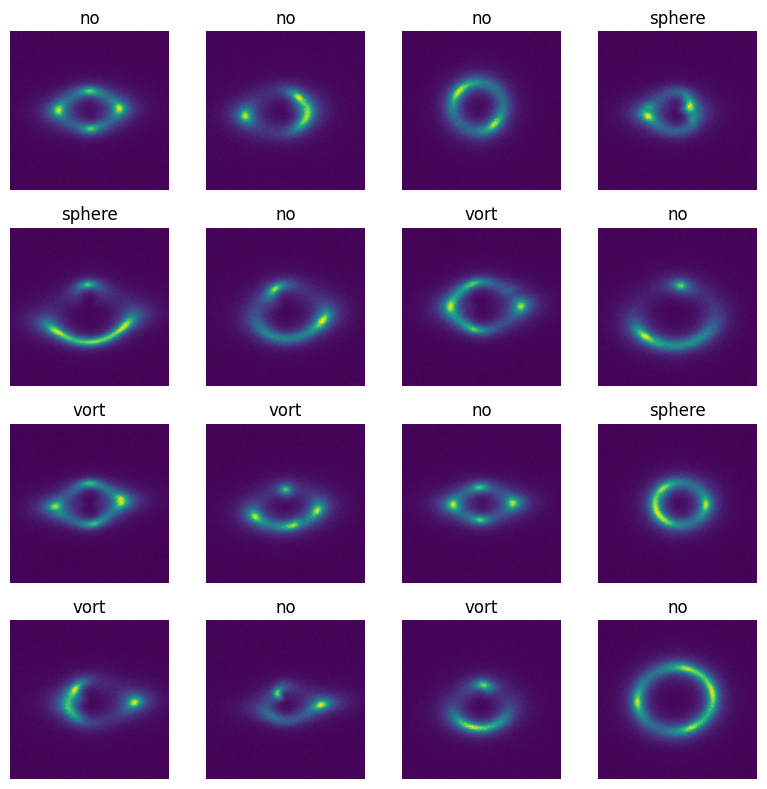

In [3]:
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Visualize some images in the train dataset
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    if i < 16:
        image, label = images[i], labels[i]

        img = image.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(train_dataset.dataset.classes[label])
        ax.axis('off')
    else:
        break

plt.tight_layout()
plt.show()

#### Define the train and test functions

In [4]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=20, save_path='./resnet18.pt'):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    } # Initialize a dictionary to store epoch-wise results
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data).item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data).item()

            val_loss /= len(val_loader.dataset)
            val_acc = val_corrects / len(val_loader.dataset)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print results
        print(f"Epoch [{epoch + 1}/{num_epochs}] w/ LR = {optimizer.param_groups[0]['lr']}")
        print(f"\tTrain Loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}")
        print(f"\tVal Loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}")

        # Step the scheduler
        if scheduler is not None:
            scheduler.step(val_loss)

        # Save the parameters with the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)

    # Load the best model
    model.load_state_dict(torch.load(save_path))

    return history, model

In [5]:
def evaluate_model(model, criterion, model_name):
    model.eval()
    y_pred_probs = []
    y_true = []
    total_loss = 0.0
    total_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            total_corrects += torch.sum(preds == labels).item()

            y_pred_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    test_loss = total_loss / len(test_loader.dataset)
    test_acc = total_corrects / len(test_loader.dataset)

    # Binarize the labels for ROC AUC
    y_true_binary = label_binarize(y_true, classes=[0, 1, 2])

    # Compute ROC AUC
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs, multi_class='ovo')
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {test_acc:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    classes = ['no', 'sphere', 'vort']

    # Plot confusion matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, np.argmax(y_pred_probs, axis=1))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Plot ROC curve for each class
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(np.array(y_true_binary).ravel(), np.array(y_pred_probs).ravel())
    plt.plot(fpr, tpr, color='orange', label=f'{model_name}, {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-Averaged ROC Curve')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

### **2/ Training and validation**

#### Declare the model

In [6]:
# Initialize ResNet18 with pre-trained weights
model = models.resnet18(weights=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)  # 1 channel
model.fc = torch.nn.Linear(model.fc.in_features, 3)  # 3 classes
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = nn.CrossEntropyLoss()

model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Train the model
history, model = train_model(model, criterion, optimizer, scheduler, num_epochs=20, save_path='./resnet18.pt')

#### Training and validation results

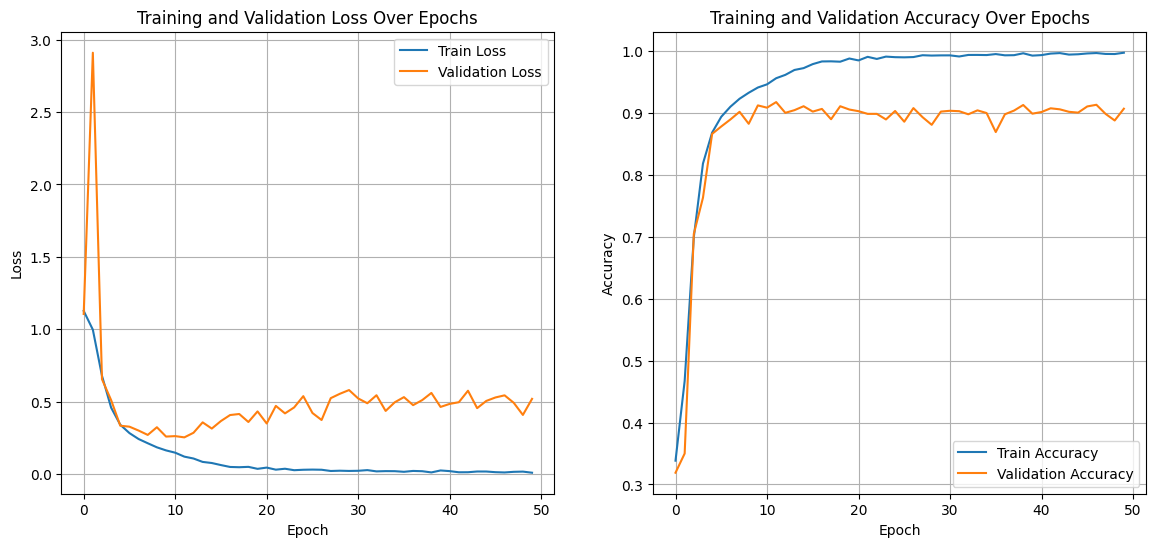

In [16]:
plt.figure(figsize=(14, 6))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

#### Model's performance on test set

Test Loss: 0.2711
Accuracy: 0.9119
ROC AUC: 0.9830


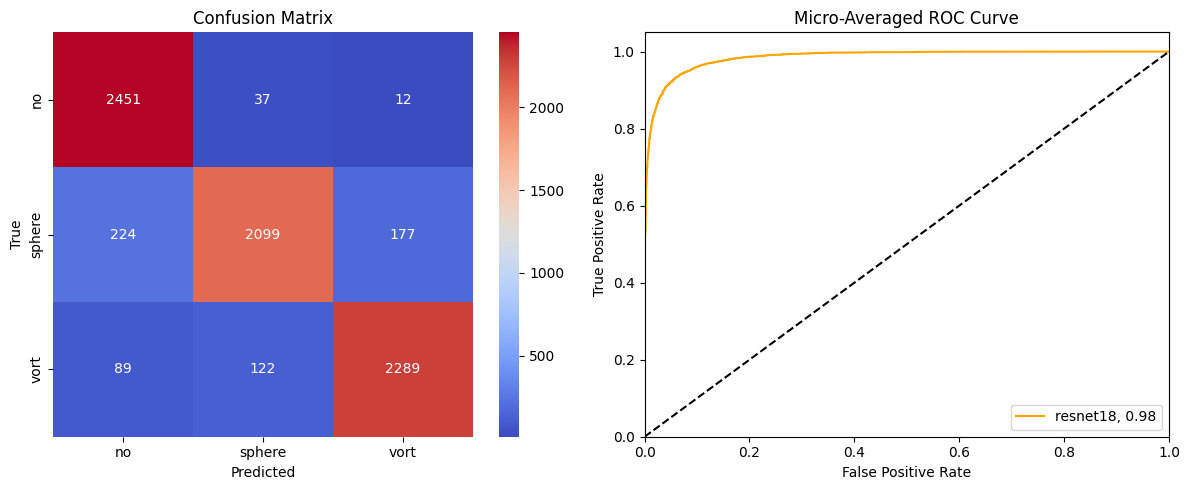

In [15]:
# Evaluate the model
evaluate_model(model, criterion, 'resnet18')